# Introduction

1. **Knapsack Problem:**
   - **Objective:** Maximize the total value of items in a knapsack without exceeding its capacity.
   - **Variables:** Binary variables indicating whether an item is included (1) or not (0).
   - **Constraints:** The total weight of the selected items must not exceed the knapsack's capacity.
   - **Formulation:**

     $$
     \begin{align*}
     \text{maximize} \quad & \sum_{i=1}^{n} v_i x_i \\
     \text{subject to} \quad & \sum_{i=1}^{n} w_i x_i \leq W \\
     & x_i \in \{0,1\}, \quad \forall i = 1, \ldots, n
     \end{align*}
     $$
     
     Where $v_i$ is the value of item $i$, $w_i$ is the weight of item $i$, $W$ is the capacity of the knapsack, and $n$ is the number of items.

2. **Traveling Salesman Problem (TSP):**
   - **Objective:** Minimize the total distance traveled while visiting each city exactly once and returning to the starting city.
   - **Variables:** Binary variables indicating whether the path between two cities is taken (1) or not (0).
   - **Constraints:** Each city must be visited exactly once; flow constraints to eliminate sub-tours.
   - **Formulation:**
     $$
     \begin{align*}
     \text{minimize} \quad & \sum_{i=1}^{n} \sum_{j \neq i, j=1}^{n} d_{ij} x_{ij} \\
     \text{subject to} \quad & \sum_{j \neq i, j=1}^{n} x_{ij} = 1, \quad \forall i \\
     & \sum_{i \neq j, i=1}^{n} x_{ij} = 1, \quad \forall j \\
     & \text{Sub-tour elimination constraints} \\
     & x_{ij} \in \{0,1\}, \quad \forall i, j
     \end{align*}
     $$
     Where $d_{ij}$ is the distance between cities $i$ and $j$, and $n$ is the number of cities.

3. **Set Covering Problem:**
   - **Objective:** Minimize the number of subsets chosen to cover all elements in a universal set.
   - **Variables:** Binary variables indicating whether a subset is chosen (1) or not (0).
   - **Constraints:** Every element in the universal set must be covered by at least one subset.
   - **Formulation:**
     $$
     \begin{align*}
     \text{minimize} \quad & \sum_{j=1}^{m} c_j x_j \\
     \text{subject to} \quad & \sum_{j: i \in S_j} x_j \geq 1, \quad \forall i \in U \\
     & x_j \in \{0,1\}, \quad \forall j
     \end{align*}
     $$
     Where $U$ is the universal set, $S_j$ are the subsets, $c_j$ is the cost of choosing subset $j$, and $m$ is the number of subsets.

4. **Vehicle Routing Problem (VRP):**
   - **Objective:** Minimize the total distance traveled to serve all customers from a central depot.
   - **Variables:** Binary variables indicating whether a route between two locations is used, and integer variables for load and routing constraints.
   - **Constraints:** Each customer must be served exactly once; vehicle capacity must not be exceeded; depot starting and ending routes.
   - **Formulation:** This is more complex due to routing and capacity constraints and often requires additional variables and constraints to model accurately.

# Facility Location (and it's derivates)

Consider we want to decide our optimal production. So, we must decide whether to build a product, which incurs a fixed cost, and the subsequent production and selling of this product at a certain price. 

Objective:
- **Objective:** Minimize the total cost, which includes the fixed costs of opening facilities and the transportation (or variable) costs of serving clients from these facilities.

Variables:
- $y_i \in \{0,1\}$: Binary variable indicating whether a facility $i$ is opened (1) or not (0).
- $x_{ij} \geq 0$: Continuous variable representing the quantity of products shipped from facility $i$ to client $j$.

Parameters:
- $F_i$: Fixed cost of opening facility $i$.
- $C_{ij}$: Variable cost per unit of shipping products from facility $i$ to client $j$.
- $D_j$: Demand of client $j$.
- $N$: Number of potential facilities.
- $M$: Number of clients.

Formulation:
$$
\begin{align*}
\text{minimize} \quad & \sum_{i=1}^{N} F_i y_i + \sum_{i=1}^{N}\sum_{j=1}^{M} C_{ij} x_{ij} \\
\text{subject to} \quad & \sum_{i=1}^{N} x_{ij} = D_j, \quad \forall j = 1, \ldots, M \\
& x_{ij} \leq D_j y_i, \quad \forall i = 1, \ldots, N, \quad \forall j = 1, \ldots, M \\
& y_i \in \{0,1\}, \quad \forall i = 1, \ldots, N \\
& x_{ij} \geq 0, \quad \forall i = 1, \ldots, N, \quad \forall j = 1, \ldots, M
\end{align*}
$$

In this formulation, the first objective component minimizes the total fixed costs of opening facilities, while the second minimizes the total variable costs associated with serving all clients from these facilities. The first set of constraints ensures that the demand of each client is exactly met by the sum of products shipped from all facilities. The second set of constraints ensures that products can only be shipped from an opened facility (if $y_i = 0$, then $x_{ij} = 0$ for all $j$), effectively linking the facility opening decisions with the shipping decisions.

In [2]:
import gurobipy as gp
from gurobipy import GRB

# function to create random instances, making so that more than one facility is needed
def generate_instance(n_facilities, n_clients):
    import random
    fixed_costs = [random.randint(1, 10) for _ in range(n_facilities)]
    serving_costs = [[random.randint(1, 10) for _ in range(n_clients)] for _ in range(n_facilities)]
    return fixed_costs, serving_costs

n_facilities = 3
n_clients = 5
fixed_costs, serving_costs = generate_instance(n_facilities, n_clients)

# Create a new model
m = gp.Model("facility_location")

# Add variables
# y[i] is 1 if facility i is open
y = m.addVars(n_facilities, vtype=GRB.BINARY, name="y")
# x[i,j] is 1 if client j is served by facility i
x = m.addVars(n_facilities, n_clients, vtype=GRB.BINARY, name="x")

# Objective: minimize total fixed and variable costs
m.setObjective(gp.quicksum(fixed_costs[i] * y[i] for i in range(n_facilities)) +
               gp.quicksum(serving_costs[i][j] * x[i, j] for i in range(n_facilities) for j in range(n_clients)),
               GRB.MINIMIZE)

# Constraints
# Each client is served by exactly one facility
for j in range(n_clients):
    m.addConstr(gp.quicksum(x[i, j] for i in range(n_facilities)) == 1, name=f"client_{j}")

# A facility must be open to serve a client
for i in range(n_facilities):
    for j in range(n_clients):
        m.addConstr(x[i, j] <= y[i], name=f"serve_{i}_{j}")

# Solve model
m.optimize()

# Display solution
if m.status == GRB.OPTIMAL:
    print(f"Optimal total cost: {m.ObjVal}")
    print("Facilities to open and their clients:")
    for i in range(n_facilities):
        if y[i].X > 0.5:  # If facility i is open
            clients_served = [j for j in range(n_clients) if x[i, j].X > 0.5]
            print(f"Facility {i} serves clients {clients_served}")


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Gentoo Linux")

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 20 rows, 18 columns and 45 nonzeros
Model fingerprint: 0x1bd59cb5
Variable types: 0 continuous, 18 integer (18 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 30.0000000
Presolve time: 0.00s
Presolved: 20 rows, 18 columns, 45 nonzeros
Variable types: 0 continuous, 18 integer (18 binary)
Found heuristic solution: objective 26.0000000

Root relaxation: cutoff, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0       

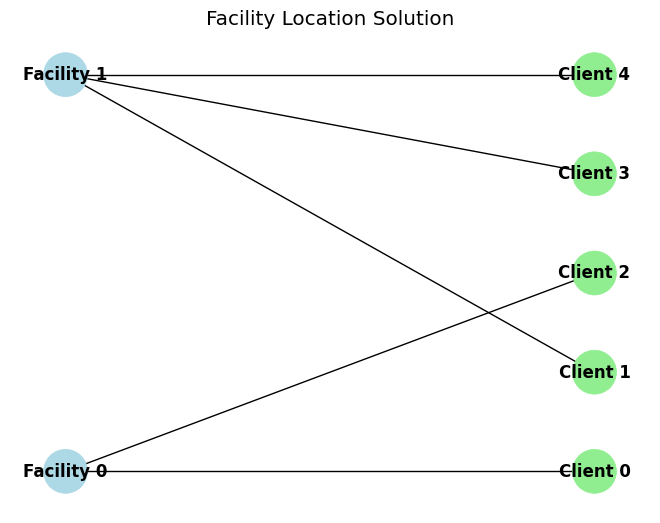

In [13]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming the facilities and clients from the solved problem are represented in the following structures:
facilities_open = [i for i in range(n_facilities) if y[i].X > 0.5]  # List of open facilities
clients_served_by_facility = {i: [j for j in range(n_clients) if x[i, j].X > 0.5] for i in facilities_open}  # Mapping of facilities to clients

# Create a graph
G = nx.Graph()

# Add nodes with the node attribute "bipartite"
facilities_nodes = ['Facility {}'.format(i) for i in facilities_open]
clients_nodes = ['Client {}'.format(j) for j in range(5)]
G.add_nodes_from(facilities_nodes, bipartite=0)  # Facilities
G.add_nodes_from(clients_nodes, bipartite=1)  # Clients

# Add edges based on the solution
for facility, clients in clients_served_by_facility.items():
    for client in clients:
        G.add_edge('Facility {}'.format(facility), 'Client {}'.format(client))

# Draw the bipartite graph
pos = nx.bipartite_layout(G, facilities_nodes)
nx.draw(G, pos, with_labels=True, node_color=['lightblue' if node in facilities_nodes else 'lightgreen' for node in G], node_size=1000, font_weight='bold')

plt.title('Facility Location Solution')
plt.show()


# Graph Coloring Problem

Given a graph $G = (V, E)$, where $V$ is the set of vertices and $E$ is the set of edges connecting the vertices, the goal is to assign colors to each vertex such that no two adjacent vertices share the same color, and to minimize the number of colors used.

Let:
- $x_{i,k} = 1$ if vertex $i$ is assigned color $k$, and $x_{i,k} = 0$ otherwise.
- $n$ be the number of vertices in the graph.
- $m$ be the number of possible colors, which in the worst case is $n$.

**Objective Function:**
Minimize the number of colors used:
$$ \min \sum_{k=1}^{m} \max_{i \in V} x_{i,k} $$

However, since we need to linearize the objective, and considering the practical implementation aspect, we aim to minimize the highest color index used:
$$ \min \sum_{i=1}^{n} \sum_{k=0}^{m-1} k \cdot x_{i,k} $$

**Subject to:**

1. Each vertex $i$ must be assigned exactly one color:
$$ \sum_{k=0}^{m-1} x_{i,k} = 1, \quad \forall i \in V $$

2. No two adjacent vertices $i$ and $j$ can share the same color:
$$ x_{i,k} + x_{j,k} \leq 1, \quad \forall (i, j) \in E, \forall k \in \{0, \ldots, m-1\} $$

3. Variable constraints:
$$ x_{i,k} \in \{0, 1\}, \quad \forall i \in V, \forall k \in \{0, \ldots, m-1\} $$

[(1, 6), (1, 9), (2, 3), (2, 5), (2, 6), (2, 7), (2, 9), (2, 10), (3, 4), (3, 5), (4, 5), (4, 10), (5, 7), (5, 8), (6, 9), (7, 8), (7, 9), (8, 9)]
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Gentoo Linux")

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 190 rows, 100 columns and 460 nonzeros
Model fingerprint: 0x5d19390a
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 90 rows and 0 columns
Presolve time: 0.00s
Presolved: 100 rows, 100 columns, 350 nonzeros
Variable types: 0 continuous, 100 integer (100 binary)
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 w

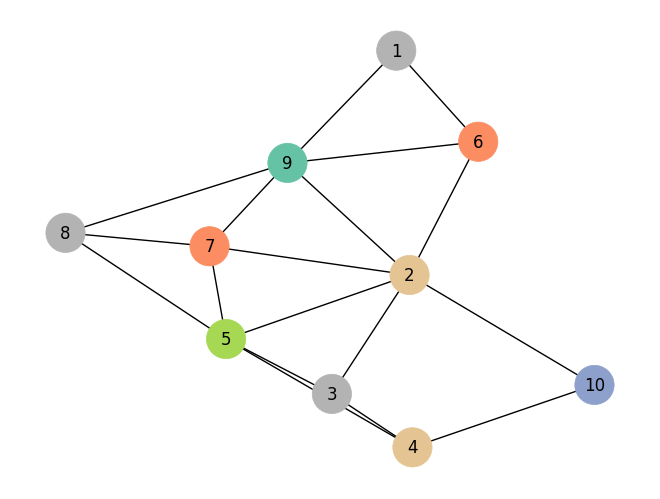

In [3]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import networkx as nx

# Define the graph
#edges = [(1, 2), (1, 3), (2, 4), (3, 4), (4, 5)]

plt.style.use('bmh')


def graph_coloring(edges):
    G = nx.Graph()
    G.add_edges_from(edges)

    # Number of vertices
    n = G.number_of_nodes()

    # Possible colors
    colors = list(range(n))  # Assuming worst case scenario: n colors

    # Create a model
    m = gp.Model()

    # Variables: x[i,k] == 1 if vertex i is assigned color k.
    x = m.addVars(G.nodes, colors, vtype=GRB.BINARY, name="x")

    # Objective: minimize the number of colors used
    m.setObjective(gp.quicksum(x[i, k] for i in G.nodes for k in colors if k == 0), GRB.MINIMIZE)

    # Constraints: Adjacent nodes cannot have the same color
    for i, j in G.edges:
        for k in colors:
            m.addConstr(x[i, k] + x[j, k] <= 1)

    # Each node must have one color
    for i in G.nodes:
        m.addConstr(gp.quicksum(x[i, k] for k in colors) == 1)

    # Solve
    m.optimize()

    # Retrieve solution
    coloring = {i: k for i in G.nodes for k in colors if x[i, k].X > 0.5}

    # Plot the graph
    colors_list = [coloring[i] for i in G.nodes]

    # plot the graph in a better way, without lines intercepting the nodes
    plt.figure()
    pos = nx.spring_layout(G)

    # define cmap color so we make a beautiful graph!
    nx.draw(G, pos, with_labels=True, node_color=colors_list, node_size=800, cmap=plt.cm.Set2)
    plt.show()

#graph_coloring(edges)

# function to auto-generate instances
def generate_graph(n):
    import random
    edges = []
    for i in range(1, n):
        for j in range(i + 1, n + 1):
            if random.random() < 0.5:
                edges.append((i, j))
    return edges
new_instance = generate_graph(10)
print(new_instance)
graph_coloring(new_instance)

# ReLU Network

Given a network with $K+1$ layers, labeling the input layer as $0$ and the output layer as $K$. The output vector $x^k$ is calculated for every layer $k \in \{ 1,\ldots, K \}$ in the range of $1$ to $K$, using the following equations:
$$
\begin{equation}
x^k =
\begin{cases}
\sigma( {\tt W}^k x^{k-1} + {\tt b}^k), & \text{if } k \neq K \\
{\tt W}^k x^{k-1} + {\tt b}^k, & \text{otherwise}
\end{cases}
\end{equation}
$$
where the weights of the neural network are given in matrix ${\tt W}^k \in \mathbb{R}^{n_k \times n_k - 1}$ and the biases are represented by ${\tt b}^k \in \mathbb{R}^{n_k}$ for each layer $k$, and $\sigma(\cdot)$ is the ReLU activation function defined as:
\begin{equation}
      \sigma(y) = \max\{0,y\}
\end{equation}

The ReLU function can be formulated as:

$$
\begin{align}
 {\tt W}^k x^{k-1} + {\tt b}^k &= x^k - s^k \\
      %%
 {\tt L}^k \leq {\tt W}^k x^{k-1} + {\tt b}^k & = x^k - s^k \leq {\tt U}^k \\
     %%
 x^k &\leq {\tt U}^k \odot z^k \\
     %%
 s^k &\leq -{\tt L} ^k\odot (1- z^k) \\
     %%
 z^k &\in \left \{0,1\right \}^{n_k} \\
    %%
    x^k, s^k &\geq 0
\end{align}
$$

Consequently, we define $x^k \in \mathbb{R}^{n_k}$ as the output from layer $k$, with $x^0$ as the network input and $x^K$ as the output.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(SimpleNN, self).__init__()
        # Define the network layers
        self.fc1 = nn.Linear(input_size, hidden_sizes[0]) # First hidden layer
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1]) # Second hidden layer
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_sizes[1], output_size) # Output layer, no ReLU

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x) # No activation function here, linear output
        return x

# Input parameters
input_size = 1
hidden_sizes = [10, 10] # Two hidden layers with 10 and 5 neurons
output_size = 1

# Instantiate the model
modelNN = SimpleNN(input_size, hidden_sizes, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(modelNN.parameters(), lr=0.01)

# Generate random data to simulate a function y = f(x)
x_train = torch.linspace(-2*np.pi, 2*np.pi, 1000).view(-1, 1)
y_train = torch.sin(x_train)# + 0.1 * torch.randn(x_train.size())  # Adding noise

# Training loop
for epoch in range(5000):
    optimizer.zero_grad()
    outputs = modelNN(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch}/1000], Loss: {loss.item():.4f}')

# get weights
rede = modelNN.state_dict()

chaves = rede.keys()
print(chaves)
weights = [rede[chave] for chave in chaves if "weight" in chave]
biases = [rede[chave] for chave in chaves if "bias" in chave]

Epoch [0/1000], Loss: 0.7172
Epoch [1000/1000], Loss: 0.0696
Epoch [2000/1000], Loss: 0.0696
Epoch [3000/1000], Loss: 0.0696
Epoch [4000/1000], Loss: 0.0698
odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


In [4]:
import gurobipy as gp
from gurobipy import GRB
import torch

def translate_to_gurobi(weightsAll, biasesAll, input_size, hidden_sizes, output_size):
    m = gp.Model("neural_network")

    # Assume L_li and U_li are given or precomputed for each neuron i in layer l
    # For simplicity, here we initialize them with some example values
    L_li = -10.0
    U_li = 10.0

    L_li = np.array([L_li] * hidden_sizes[0]).reshape(-1, 1)
    U_li = np.array([U_li] * hidden_sizes[0]).reshape(-1, 1)

    ones = np.ones(hidden_sizes[0]).reshape(-1, 1)
    zeros = np.zeros(hidden_sizes[0]).reshape(-1, 1)

    tamanho_rede = len(weightsAll)

    # Input layer
    input_vars = m.addMVar((1,1), lb=-2*np.pi, ub=2*np.pi, name="x_0")

    prev_output = input_vars
    neuron_idx_global = 0  # To keep track of global neuron index across layers
    
    # set unboundinfo
    m.setParam ( "InfUnbdInfo", 1 )


    layer_vars_x = []
    layer_vars_x.append(input_vars.T)
    
    #i = 1
    for i in range(tamanho_rede):

        print(f"Layer {i}")      
        # get the weights and biases
        weights = weightsAll[i].detach().numpy()

        #print(weights)
        biases = biasesAll[i].detach().numpy().reshape(-1, 1)
        print(biases.shape)

        if i < tamanho_rede -1:  # No ReLU after the last layer

            # Variables for the layer's output
            layer_vars_s = m.addMVar(biases.shape, lb=0, name=f"s_{i+1}")
            layer_vars_x.append(m.addMVar(biases.shape, lb=0, name=f"x_{i+1}"))

            z_vars_layer = m.addMVar(biases.shape, vtype=GRB.BINARY, name=f"relu_{i}_z")
            m.update()

            lhs = (layer_vars_x[i+1] - layer_vars_s)
            rhs = (weights @ layer_vars_x[i] + biases)

            print(lhs.shape)

            for k in range(lhs.shape[0]):
                print(lhs[k] - rhs[k])
                m.addConstr(lhs[k] == rhs[k], name=f"layer_{i+1}_{i}")

            rhs = -L_li * (ones - z_vars_layer)

            print(rhs)
            for k in range(rhs.shape[0]):
                m.addConstr(layer_vars_s[k] <= rhs[k], name=f"layer_{i+1}_{i}")

            rhs = U_li * z_vars_layer
            print(rhs)

            for k in range(rhs.shape[0]):
                m.addConstr(layer_vars_x[i+1][k] <= rhs[k], name=f"layer_{i+1}_{i}")
            i += 1
        else:
            layer_vars_x.append(m.addMVar(weights.shape, lb=-GRB.INFINITY, name=f"x_{i+1}"))
            expr = (layer_vars_x[i+1]) - (weights @ layer_vars_x[i] + biases)
            m.addConstr(expr == 0, name=f"layer_{i+1}")

    m.update()  # Integrate new variables and constraints
    return m, layer_vars_x  # Return model and the output variables of the last layer

m, output_var = translate_to_gurobi(weights, biases, 1, [10], 1) 
# print all the model equations looking through constraints and variables

m.update()

variables = m.getVars()
# iterate over constraints
A = m.getA().toarray()
for i in range(A.shape[0]):
    expr = ""
    for j in range(A.shape[1]):
        if A[i, j] != 0:
            var = variables[j]
            expr += f"{A[i, j]:.2f} * {var.varName} + "

ones = np.ones(output_var[-1].shape)
m.setObjective(ones @ output_var[-1].T, GRB.MAXIMIZE)
m.optimize()
for var in output_var[0]:
    print(f"{var.varName} = {var.x}")


Set parameter InfUnbdInfo to value 1
Layer 0
(10, 1)
(10, 1)
<MLinExpr (1,)>
array([ 0.6931997537612915 + x_1[0,0] + -1.0 s_1[0,0] + -0.5960100293159485 x_0[0,0]])
<MLinExpr (1,)>
array([ 0.9242305159568787 + x_1[1,0] + -1.0 s_1[1,0] + 0.42153066396713257 x_0[0,0]])
<MLinExpr (1,)>
array([ 0.838253378868103 + x_1[2,0] + -1.0 s_1[2,0] + 0.45590612292289734 x_0[0,0]])
<MLinExpr (1,)>
array([ -0.49514856934547424 + x_1[3,0] + -1.0 s_1[3,0] + -0.47089582681655884 x_0[0,0]])
<MLinExpr (1,)>
array([ -0.8527660965919495 + x_1[4,0] + -1.0 s_1[4,0] + 0.05519668757915497 x_0[0,0]])
<MLinExpr (1,)>
array([ -0.6370226740837097 + x_1[5,0] + -1.0 s_1[5,0] + -0.43314000964164734 x_0[0,0]])
<MLinExpr (1,)>
array([ -0.30263012647628784 + x_1[6,0] + -1.0 s_1[6,0] + -0.5143182277679443 x_0[0,0]])
<MLinExpr (1,)>
array([ -1.107374906539917 + x_1[7,0] + -1.0 s_1[7,0] + -0.13996200263500214 x_0[0,0]])
<MLinExpr (1,)>
array([ 0.4554107189178467 + x_1[8,0] + -1.0 s_1[8,0] + -0.4362141788005829 x_0[0,0]])
<MLi


# N-Queens

The goal is to place N queens on an N×N chessboard so that no two queens attack each other. This means no two queens can be in the same row, column, or diagonal.


The decision variable $x_{i,j}$ is a binary variable that is 1 if a queen is placed on row $i$ and column $j$, and 0 otherwise.

The mathematical model is:

- **Objective Function**: There's no actual objective to maximize or minimize in this problem; we're simply seeking a feasible solution that satisfies the constraints.

- **Constraints**:

1. **Row Constraint**: Ensure only one queen per row.
$$
\sum_{j=1}^{N} x_{i,j} = 1, \quad \forall i \in \{1, ..., N\}
$$

2. **Column Constraint**: Ensure only one queen per column.
$$
\sum_{i=1}^{N} x_{i,j} = 1, \quad \forall j \in \{1, ..., N\}
$$

3. **Diagonal Constraint**: Ensure only one queen per diagonal.
For the diagonals, we need two sets of constraints for each of the two diagonal directions.

- **Ascending Diagonal Constraint**:
$$
\sum_{i=1}^{N}\sum_{j=1}^{N} x_{i,j} \cdot \delta_{i-j=k} \leq 1, \quad \forall k \in \{-N+1, ..., N-1\}
$$
where $\delta$ is an indicator function that is 1 if $i-j=k$ and 0 otherwise.

- **Descending Diagonal Constraint**:
$$
\sum_{i=1}^{N}\sum_{j=1}^{N} x_{i,j} \cdot \delta_{i+j=k} \leq 1, \quad \forall k \in \{2, ..., 2N\}
$$
where $\delta$ is an indicator function that is 1 if $i+j=k$ and 0 otherwise.


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Gentoo Linux")

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 46 rows, 64 columns and 256 nonzeros
Model fingerprint: 0xc537e5e0
Variable types: 0 continuous, 64 integer (64 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 32 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
[[0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0]]


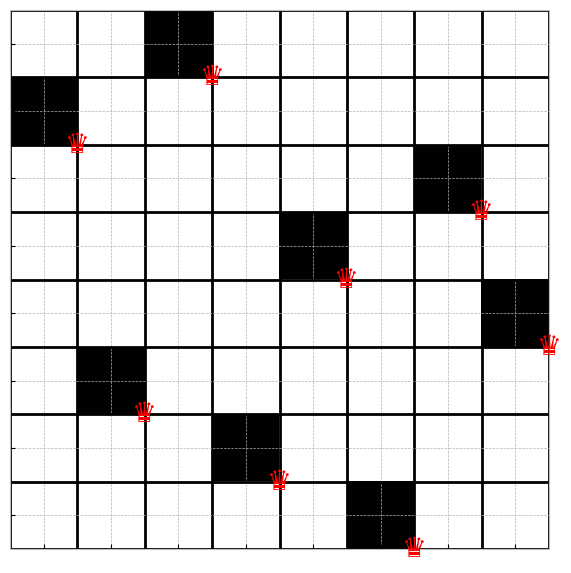

In [6]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

def solve_n_queens(N):
    # Model
    m = gp.Model("n_queens")

    # Variables
    x = m.addVars(N, N, vtype=GRB.BINARY, name="x")

    # Constraints

    # Row constraint
    for i in range(N):
        m.addConstr(sum(x[i,j] for j in range(N)) == 1)

    # Column constraint
    for j in range(N):
        m.addConstr(sum(x[i,j] for i in range(N)) == 1)

    # Diagonal constraints
    for p in range(-N+1, N):
        m.addConstr(sum(x[i, i+p] for i in range(N) if 0 <= i+p < N) <= 1)
        m.addConstr(sum(x[i, j] for i in range(N) for j in range(N) if i+j == p+N-1) <= 1)

    # Solve model
    m.optimize()

    # Extract solution
    if m.status == GRB.OPTIMAL:
        sol = m.getAttr('x', x)
        board = np.zeros((N,N), int)
        for i in range(N):
            for j in range(N):
                if sol[i,j] > 0.5:
                    board[i,j] = 1
        return board
    else:
        return None

# Example: Solve 8-queens problem
N = 8
solution = solve_n_queens(N)
print(solution)

import matplotlib.pyplot as plt

def plot_solution(solution):
    N = solution.shape[0]
    plt.figure(figsize=(7,7))  # Adjust figure size as needed
    plt.imshow(solution, cmap='binary', interpolation='nearest')
    plt.xticks(range(N), [])
    plt.yticks(range(N), [])
    #plt.grid(color='black', linestyle='-', linewidth=1.5)
    ax = plt.gca()  # Get current axes
    ax.set_xticks(np.arange(-.5, N, 1), minor=True)
    ax.set_yticks(np.arange(-.5, N, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    
    # Adjust the text position
    offset = 0.5
    for i in range(N):
        for j in range(N):
            if solution[i,j] == 1:
                plt.text(j + offset, i + offset, '♛', fontsize=20, ha='center', va='center', color='red')

    plt.show()

if solution is not None:
    plot_solution(solution)

# Shortest Path Problem

To formulate a shortest path problem as a Mixed Integer Programming (MIP) problem and solve it using Gurobi, we first define the problem context. Let's consider a directed graph $G = (V, E)$ where $V$ is the set of vertices and $E$ is the set of edges. Each edge $(i, j) \in E$ has a corresponding cost or distance $c_{ij}$. The goal is to find the shortest path from a source node $s$ to a target node $t$.

### MIP Formulation

- **Decision Variables**:
  - Let $x_{ij}$ be a binary variable that is 1 if edge $(i, j)$ is included in the shortest path and 0 otherwise.

- **Objective Function**:
  - Minimize the total cost of the selected edges in the path.
  $$
  \text{Minimize } \sum_{(i,j) \in E} c_{ij} x_{ij}
  $$

- **Constraints**:
  1. **Flow Conservation**:
     - Ensure that the sum of the incoming flows is equal to the sum of the outgoing flows for all intermediate nodes.
     $$
     \sum_{(i,j) \in E} x_{ij} - \sum_{(j,i) \in E} x_{ji} = \begin{cases} 
     1 & \text{if } i = s \\
     -1 & \text{if } i = t \\
     0 & \text{otherwise} 
     \end{cases}
     $$
  2. **Binary Constraints**:
     - Each decision variable is binary.
     $$
     x_{ij} \in \{0, 1\}, \quad \forall (i,j) \in E
     $$


In [9]:
import gurobipy as gp
from gurobipy import GRB

N = 7
# function to create random instance for the shortest path problem
# n is the number of nodes, we also need to define the source and target nodes
# along with the edges and their costs
def generate_shortest_path(n):
    import random
    source = 1
    target = n
    edges = []
    costs = {}
    for i in range(1, n):
        for j in range(i + 1, n + 1):
            if random.random() < 0.5:
                edges.append((i, j))
                costs[(i, j)] = random.randint(1, 10)
    return source, target, edges, costs

source, target, edges, costs = generate_shortest_path(N)
print('source', source)
print('target', target)

# Model
m = gp.Model("shortest_path_simple")

# Variables: x[i, j] = 1 if edge (i, j) is in the shortest path
x = m.addVars(edges, vtype=GRB.BINARY, name="x")

# Objective: Minimize total cost of the path
m.setObjective(gp.quicksum(costs[e] * x[e] for e in edges), GRB.MINIMIZE)

# Add flow conservation constraints
m.addConstrs((gp.quicksum(x[i, j] for i, j in edges if i == k) -
              gp.quicksum(x[j, i] for j, i in edges if i == k) == (1 if k == source else -1 if k == target else 0)
              for k in range(1, N)), name="flow")


m.optimize()

# Check and print the solution
if m.status == GRB.OPTIMAL:
    print("Solution found:")
    for e in edges:
        if x[e].X > 0.1:  # If edge is in the solution
            print(f"Edge {e} is in the shortest path.")
else:
    print("The model did not find a solution.")


source 1
target 7
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Gentoo Linux")

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 6 rows, 10 columns and 17 nonzeros
Model fingerprint: 0xa600a617
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 6 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 32 available processors)

Solution count 1: 5 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.000000000000e+00, best bound 5.000000000000e+00, gap 0.0000%
Solution found:
Edge (1, 2) is in the shortest path.
Edge (2, 7) is in the shortest pa

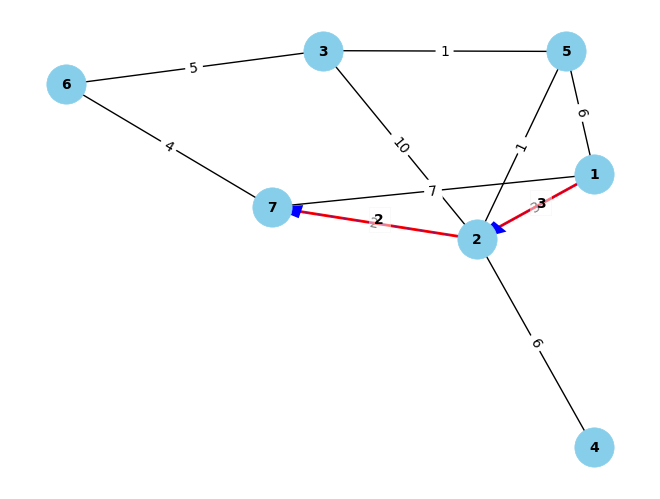

In [10]:
import networkx as nx
import matplotlib.pyplot as plt


def plot_shortest_path(edges, solution):
    G = nx.Graph()
    G.add_edges_from(edges)

    # Plot the graph
    plt.figure()
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=800, node_color='skyblue', font_size=10, font_weight='bold')
    # add costs to the edges
    nx.draw_networkx_edge_labels(G, pos, edge_labels=costs)

    # Highlight the edges in the solution
    for e in edges:
        if solution[e].X > 0.1:
            nx.draw_networkx_edges(G, pos, edgelist=[e], edge_color='r', width=2)
            # Add the cost of the edge
            plt.text((pos[e[0]][0] + pos[e[1]][0]) / 2, (pos[e[0]][1] + pos[e[1]][1]) / 2, costs[e], fontweight='bold', bbox=dict(facecolor='white', alpha=0.5))
            # add arrows to the edges
            plt.arrow(pos[e[0]][0], pos[e[0]][1], pos[e[1]][0] - pos[e[0]][0], pos[e[1]][1] - pos[e[0]][1], shape='full', lw=0, length_includes_head=True, head_width=.05)

    plt.show()

# Plot the solution
plot_shortest_path(edges, x)